<a href="https://colab.research.google.com/github/HarshavardhanBhupathi/Data-science/blob/main/Customer_churn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUSTOMER CHURN CLASSIFICATION USING XGBOOST ALGORITHM

In [106]:
import pandas as pd
import numpy as np
import xgboost as xb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score,balanced_accuracy_score,make_scorer

In [107]:
cc=pd.read_excel(r"/home/CustomerChurn.xlsx")

In [108]:
cc.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

In [109]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LoyaltyID          7043 non-null   int64  
 1   Customer_ID        7043 non-null   object 
 2   Senior_Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure             7043 non-null   int64  
 6   Phone_Service      7043 non-null   object 
 7   Multiple_Lines     7043 non-null   object 
 8   Internet_Service   7043 non-null   object 
 9   Online_Security    7043 non-null   object 
 10  Online_Backup      7043 non-null   object 
 11  Device_Protection  7043 non-null   object 
 12  Tech_Support       7043 non-null   object 
 13  Streaming_TV       7043 non-null   object 
 14  Streaming_Movies   7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  Paperless_Billing  7043 

In [110]:
cc.isnull().sum()

LoyaltyID            0
Customer_ID          0
Senior_Citizen       0
Partner              0
Dependents           0
Tenure               0
Phone_Service        0
Multiple_Lines       0
Internet_Service     0
Online_Security      0
Online_Backup        0
Device_Protection    0
Tech_Support         0
Streaming_TV         0
Streaming_Movies     0
Contract             0
Paperless_Billing    0
Payment_Method       0
Monthly_Charges      0
Total_Charges        0
Churn                0
dtype: int64

In [111]:
cc.shape

(7043, 21)

In [112]:
cc.loc[cc['Total_Charges']==' ']

,LoyaltyID,Customer_ID,Senior_Citizen,Partner,Dependents,Tenure,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn
488,344543,4472-LVYGI,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,150036,3115-CZMZD,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,497688,5709-LVOEQ,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,158969,4367-NUYAO,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,470044,1371-DWPAZ,No,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,937662,7644-OMVMY,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,821083,3213-VVOLG,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,947028,2520-SGTTA,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,135257,2923-ARZLG,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,317862,4075-WKNIU,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [113]:
cc.loc[(cc['Total_Charges']==' '),'Total_Charges']=0 ##converting empty values into 0's

In [114]:
cc['Total_Charges']=pd.to_numeric(cc['Total_Charges'])

In [115]:
cc.dtypes

LoyaltyID              int64
Customer_ID           object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure                 int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn                 object
dtype: object

In [116]:
cc['Senior_Citizen'].unique()

array(['No', 'Yes'], dtype=object)

In [117]:
cc['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [118]:
cc.replace(' ','_',regex=True,inplace=True) ##just for Xgboost tree display

In [119]:
cc

,LoyaltyID,Customer_ID,Senior_Citizen,Partner,Dependents,Tenure,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,810338,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One_year,Yes,Mailed_check,84.80,1990.50,No
7039,230811,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,One_year,Yes,Credit_card_(automatic),103.20,7362.90,No
7040,155157,4801-JZAZL,No,Yes,Yes,11,No,No_phone_service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic_check,29.60,346.45,No
7041,731782,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed_check,74.40,306.60,Yes


In [120]:
cc.columns

Index(['LoyaltyID', 'Customer_ID', 'Senior_Citizen', 'Partner', 'Dependents',
       'Tenure', 'Phone_Service', 'Multiple_Lines', 'Internet_Service',
       'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support',
       'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing',
       'Payment_Method', 'Monthly_Charges', 'Total_Charges', 'Churn'],
      dtype='object')

Splitting data into x and y; where the columns in x  used tomake classifications and column y which is to be predicted.

In [121]:
x=cc.drop(['Churn','LoyaltyID','Customer_ID'],axis=1)

In [122]:
x.columns

Index(['Senior_Citizen', 'Partner', 'Dependents', 'Tenure', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges'],
      dtype='object')

In [123]:
y=cc['Churn']

Its important to use One -hot encoding on categorical variables to make it look like continous variables 

In [124]:
x.dtypes 

Senior_Citizen        object
Partner               object
Dependents            object
Tenure                 int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

In [125]:
x['Senior_Citizen'].unique()

array(['No', 'Yes'], dtype=object)

In [126]:
x['Partner'].unique()



array(['Yes', 'No'], dtype=object)

In [127]:
x['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [128]:
x['Paperless_Billing'].unique()

array(['Yes', 'No'], dtype=object)

In [129]:
x['Phone_Service'].unique()

array(['No', 'Yes'], dtype=object)

In [130]:
x['Multiple_Lines'].unique()

array(['No_phone_service', 'No', 'Yes'], dtype=object)

In [131]:
x['Internet_Service'].unique()

array(['DSL', 'Fiber_optic', 'No'], dtype=object)

In [132]:
x['Online_Backup'].unique()

array(['Yes', 'No', 'No_internet_service'], dtype=object)

In [133]:
x['Online_Security'].unique()

array(['No', 'Yes', 'No_internet_service'], dtype=object)

In [134]:
x['Device_Protection'].unique()

array(['No', 'Yes', 'No_internet_service'], dtype=object)

In [135]:
x['Payment_Method'].unique()

array(['Electronic_check', 'Mailed_check', 'Bank_transfer_(automatic)',
       'Credit_card_(automatic)'], dtype=object)

In [136]:
x['Tech_Support'].unique()

array(['No', 'Yes', 'No_internet_service'], dtype=object)

In [137]:
x['Streaming_Movies'].unique()

array(['No', 'Yes', 'No_internet_service'], dtype=object)

In [138]:
x['Streaming_TV'].unique()

array(['No', 'Yes', 'No_internet_service'], dtype=object)

In [139]:
x=pd.get_dummies(x,columns=['Senior_Citizen','Partner','Dependents','Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',])

In [140]:
x.dtypes

Tenure                                        int64
Monthly_Charges                             float64
Total_Charges                               float64
Senior_Citizen_No                             uint8
Senior_Citizen_Yes                            uint8
Partner_No                                    uint8
Partner_Yes                                   uint8
Dependents_No                                 uint8
Dependents_Yes                                uint8
Phone_Service_No                              uint8
Phone_Service_Yes                             uint8
Multiple_Lines_No                             uint8
Multiple_Lines_No_phone_service               uint8
Multiple_Lines_Yes                            uint8
Internet_Service_DSL                          uint8
Internet_Service_Fiber_optic                  uint8
Internet_Service_No                           uint8
Online_Security_No                            uint8
Online_Security_No_internet_service           uint8
Online_Secur

In [141]:
x.head()

,Tenure,Monthly_Charges,Total_Charges,Senior_Citizen_No,Senior_Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone_Service_No,Phone_Service_Yes,Multiple_Lines_No,Multiple_Lines_No_phone_service,Multiple_Lines_Yes,Internet_Service_DSL,Internet_Service_Fiber_optic,Internet_Service_No,Online_Security_No,Online_Security_No_internet_service,Online_Security_Yes,Online_Backup_No,Online_Backup_No_internet_service,Online_Backup_Yes,Device_Protection_No,Device_Protection_No_internet_service,Device_Protection_Yes,Tech_Support_No,Tech_Support_No_internet_service,Tech_Support_Yes,Streaming_TV_No,Streaming_TV_No_internet_service,Streaming_TV_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,1,29.85,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [142]:
y.unique()

array(['No', 'Yes'], dtype=object)

In [143]:
y

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
7038     No
7039     No
7040     No
7041    Yes
7042     No
Name: Churn, Length: 7043, dtype: object

In [144]:
y=y.replace(['Yes','No'],['1','0'])

In [145]:
y=y.astype(int)

In [146]:
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [147]:
sum(y)

1869

In [148]:
sum(y)/len(y)

0.2653698707936959

Here we can observe that around 27 % of customers who left or disconnected with the company 

So to maintain this percentage during training and splitting we use stratify attribute 

In [149]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,stratify=y)

Building Premilinary Model

In [150]:
xgbcl=xb.XGBClassifier(objective="binary:logistic",missing=None,seed=42)

We gonna use early stopping attribute to stop building tree when there is no longer optimisation rather defining optimal number of trees with CV

In [151]:
xgbcl.fit(x_train,y_train,verbose=True,early_stopping_rounds=10,eval_metric='aucpr',eval_set=[(x_test,y_test)])

[0]	validation_0-aucpr:0.579067
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.581273
[2]	validation_0-aucpr:0.594607
[3]	validation_0-aucpr:0.595215
[4]	validation_0-aucpr:0.596482
[5]	validation_0-aucpr:0.598574
[6]	validation_0-aucpr:0.631769
[7]	validation_0-aucpr:0.638008
[8]	validation_0-aucpr:0.638729
[9]	validation_0-aucpr:0.63937
[10]	validation_0-aucpr:0.63839
[11]	validation_0-aucpr:0.641466
[12]	validation_0-aucpr:0.641945
[13]	validation_0-aucpr:0.641556
[14]	validation_0-aucpr:0.640274
[15]	validation_0-aucpr:0.64372
[16]	validation_0-aucpr:0.645566
[17]	validation_0-aucpr:0.645732
[18]	validation_0-aucpr:0.647367
[19]	validation_0-aucpr:0.64633
[20]	validation_0-aucpr:0.647219
[21]	validation_0-aucpr:0.647022
[22]	validation_0-aucpr:0.647085
[23]	validation_0-aucpr:0.649197
[24]	validation_0-aucpr:0.650565
[25]	validation_0-aucpr:0.649892
[26]	validation_0-aucpr:0.649925
[27]	validation_0-aucpr:0.649745
[28]	validation_0-aucpr:

XGBClassifier(seed=42)

In [152]:
## Lets perform on Testing Dataset and Display Confusion Matrix|

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


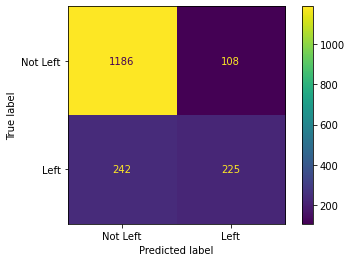

In [153]:
plot_confusion_matrix(xgbcl,x_test,y_test,display_labels=['Not Left','Left'])

SO from the above matrix, We could see that out of 1294 people who are connected with company , 1186 i.e which is around 91% were correctly classified by our model. Similarly out of 467 who left,225 were correctly classified which is <50% correctly classified .
So due to data imbalance XgBoost doesnot look great here. AS we can see in the data.But whats more important is more efficient  predictions on people who left as it going to cost lot of factors for a company. So xgboost has another surprise for us.Its **Scale_pos_weight** which deals with imbalanced data.

Lets optimize parameters using Cross Validation

In [154]:
param_grid= {'max_depth': [4],'learning_rate': [0.1,4,5],'gamma':[0.25],'reg_lambda':[10,40,100],'scale_pos_weight': [3,6]}

In [155]:
op=GridSearchCV(estimator=xb.XGBClassifier(objective='binary:logistic',seed=42,subsample=0.9,colsample_bytree=0.5),param_grid=param_grid,scoring='roc_auc',verbose=0,n_jobs=10,cv=3)

In [156]:
op.fit(x_train,y_train,early_stopping_rounds=10,eval_metric='auc',eval_set=[(x_test,y_test)],verbose=False)

GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.5, seed=42,
                                     subsample=0.9),
             n_jobs=10,
             param_grid={'gamma': [0.25], 'learning_rate': [0.1, 4, 5],
                         'max_depth': [4], 'reg_lambda': [10, 40, 100],
                         'scale_pos_weight': [3, 6]},
             scoring='roc_auc')

In [157]:
print(op.best_params_)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 100, 'scale_pos_weight': 6}


In [158]:
xgbcl1=xb.XGBClassifier(objective="binary:logistic",gamma= 0.25, learning_rate= 0.1,max_depth= 4, reg_lambda= 100, scale_pos_weight= 6,colsample_bytree=0.5, seed=42,
                                     subsample=0.9)

In [159]:
xgbcl1.fit(x_train,y_train,verbose=True,early_stopping_rounds=10,eval_metric='aucpr',eval_set=[(x_test,y_test)])

[0]	validation_0-aucpr:0.487346
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.513758
[2]	validation_0-aucpr:0.510992
[3]	validation_0-aucpr:0.551671
[4]	validation_0-aucpr:0.578224
[5]	validation_0-aucpr:0.580117
[6]	validation_0-aucpr:0.581604
[7]	validation_0-aucpr:0.592495
[8]	validation_0-aucpr:0.597801
[9]	validation_0-aucpr:0.605416
[10]	validation_0-aucpr:0.605757
[11]	validation_0-aucpr:0.606399
[12]	validation_0-aucpr:0.608691
[13]	validation_0-aucpr:0.613787
[14]	validation_0-aucpr:0.614525
[15]	validation_0-aucpr:0.615427
[16]	validation_0-aucpr:0.615616
[17]	validation_0-aucpr:0.620145
[18]	validation_0-aucpr:0.619841
[19]	validation_0-aucpr:0.617676
[20]	validation_0-aucpr:0.617366
[21]	validation_0-aucpr:0.617326
[22]	validation_0-aucpr:0.636502
[23]	validation_0-aucpr:0.6374
[24]	validation_0-aucpr:0.636109
[25]	validation_0-aucpr:0.635635
[26]	validation_0-aucpr:0.633412
[27]	validation_0-aucpr:0.634112
[28]	validation_0-aucp

XGBClassifier(colsample_bytree=0.5, gamma=0.25, max_depth=4, reg_lambda=100,
              scale_pos_weight=6, seed=42, subsample=0.9)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


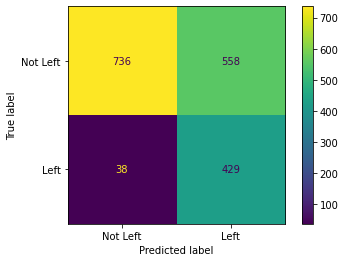

In [160]:
plot_confusion_matrix(xgbcl1,x_test,y_test,display_labels=['Not Left','Left'])

In [161]:
## Now from confusion matrix we could observe the optimised xgboost for the people who left the company buut yes at the cost of effectiveness  people who not left the company
## out of 467 , 429 have been correctly identified.

In [162]:
xgbcl1=xb.XGBClassifier(objective="binary:logistic",gamma= 0.25, learning_rate= 0.1,max_depth= 4, reg_lambda= 100, scale_pos_weight= 6,colsample_bytree=0.5, seed=42,
                                     subsample=0.9,n_estimators=1)
xgbcl1.fit(x_train,y_train)

XGBClassifier(colsample_bytree=0.5, gamma=0.25, max_depth=4, n_estimators=1,
              reg_lambda=100, scale_pos_weight=6, seed=42, subsample=0.9)

In [163]:
## Lets draw xgboost tree to get information like gain and cover 
## so just build the first tree

In [164]:
bs=xgbcl1.get_booster()

In [165]:
for i in ('weight','gain','cover','total_gain','total_cover'):
  print('%s '%i,bs.get_score(importance_type=i))

weight  {'Contract_Two_year': 1, 'Contract_One_year': 1, 'Internet_Service_No': 1, 'Online_Security_No': 1, 'Total_Charges': 2, 'Streaming_Movies_Yes': 1, 'Monthly_Charges': 3}
gain  {'Contract_Two_year': 1443.89099, 'Contract_One_year': 709.337891, 'Internet_Service_No': 198.806396, 'Online_Security_No': 20.3964844, 'Total_Charges': 30.2573147, 'Streaming_Movies_Yes': 110.424713, 'Monthly_Charges': 16.111308893333334}
cover  {'Contract_Two_year': 2760.75, 'Contract_One_year': 2431.0, 'Internet_Service_No': 2041.0, 'Online_Security_No': 1884.5, 'Total_Charges': 114.875, 'Streaming_Movies_Yes': 390.0, 'Monthly_Charges': 200.5}
total_gain  {'Contract_Two_year': 1443.89099, 'Contract_One_year': 709.337891, 'Internet_Service_No': 198.806396, 'Online_Security_No': 20.3964844, 'Total_Charges': 60.5146294, 'Streaming_Movies_Yes': 110.424713, 'Monthly_Charges': 48.333926680000005}
total_cover  {'Contract_Two_year': 2760.75, 'Contract_One_year': 2431.0, 'Internet_Service_No': 2041.0, 'Online_Se

In [166]:
node_params={'shape':'box','style':'filled,rounded','fillcolor':'#78cbe'}
leaf_params={'shape':'box','style':'filled','fillcolor':'#e48038'}

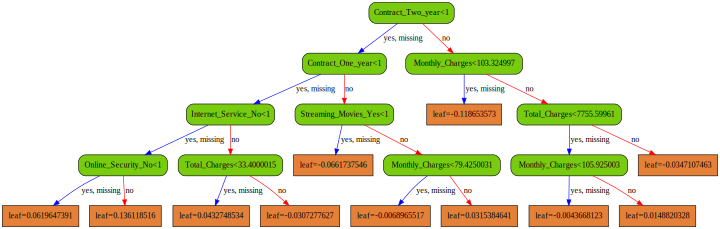

In [167]:

xb.to_graphviz(xgbcl1,num_trees=0,size="10,10",condition_node_params=node_params,leaf_node_params=leaf_params)